# Steane符号と論理ビット操作

このノートブックでは、Steaneの符号における論理Tゲート操作について、簡単に説明する。

# ライブラリのインポート

In [ ]:
%pip install qiskit qiskit-aer
%pip install pylatexenc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import pauli_error
from qiskit_aer.noise.errors.base_quantum_error import QuantumChannelInstruction

In [ ]:
n_shots = 1000 # シミュレーターでのサンプリング回数
backend_sim = AerSimulator() # シミュレーターの用意

# Tゲートを用いた回路

Tゲートの効果が観測できるシンプルな1量子ビットの回路を作ります。

In [ ]:
n_qubits = 1
circ = QuantumCircuit(n_qubits, 1)

circ.h(0)
circ.t(0)
circ.h(0)

circ.measure(0, 0)
circ.draw("mpl")

In [ ]:
result = backend_sim.run(circ, shots=n_shots).result()
plot_histogram(result.get_counts(0))

このとき、|0>が観測される確率は$\frac{2+\sqrt{2}}{4}=0.86$になります。

# Tゲートの量子テレポーテーション

まず、符号化された世界で議論する前に、論理Tゲートを理解するために重要な、量子ゲートテレポーテーションの概念を実感するための回路を作ります。

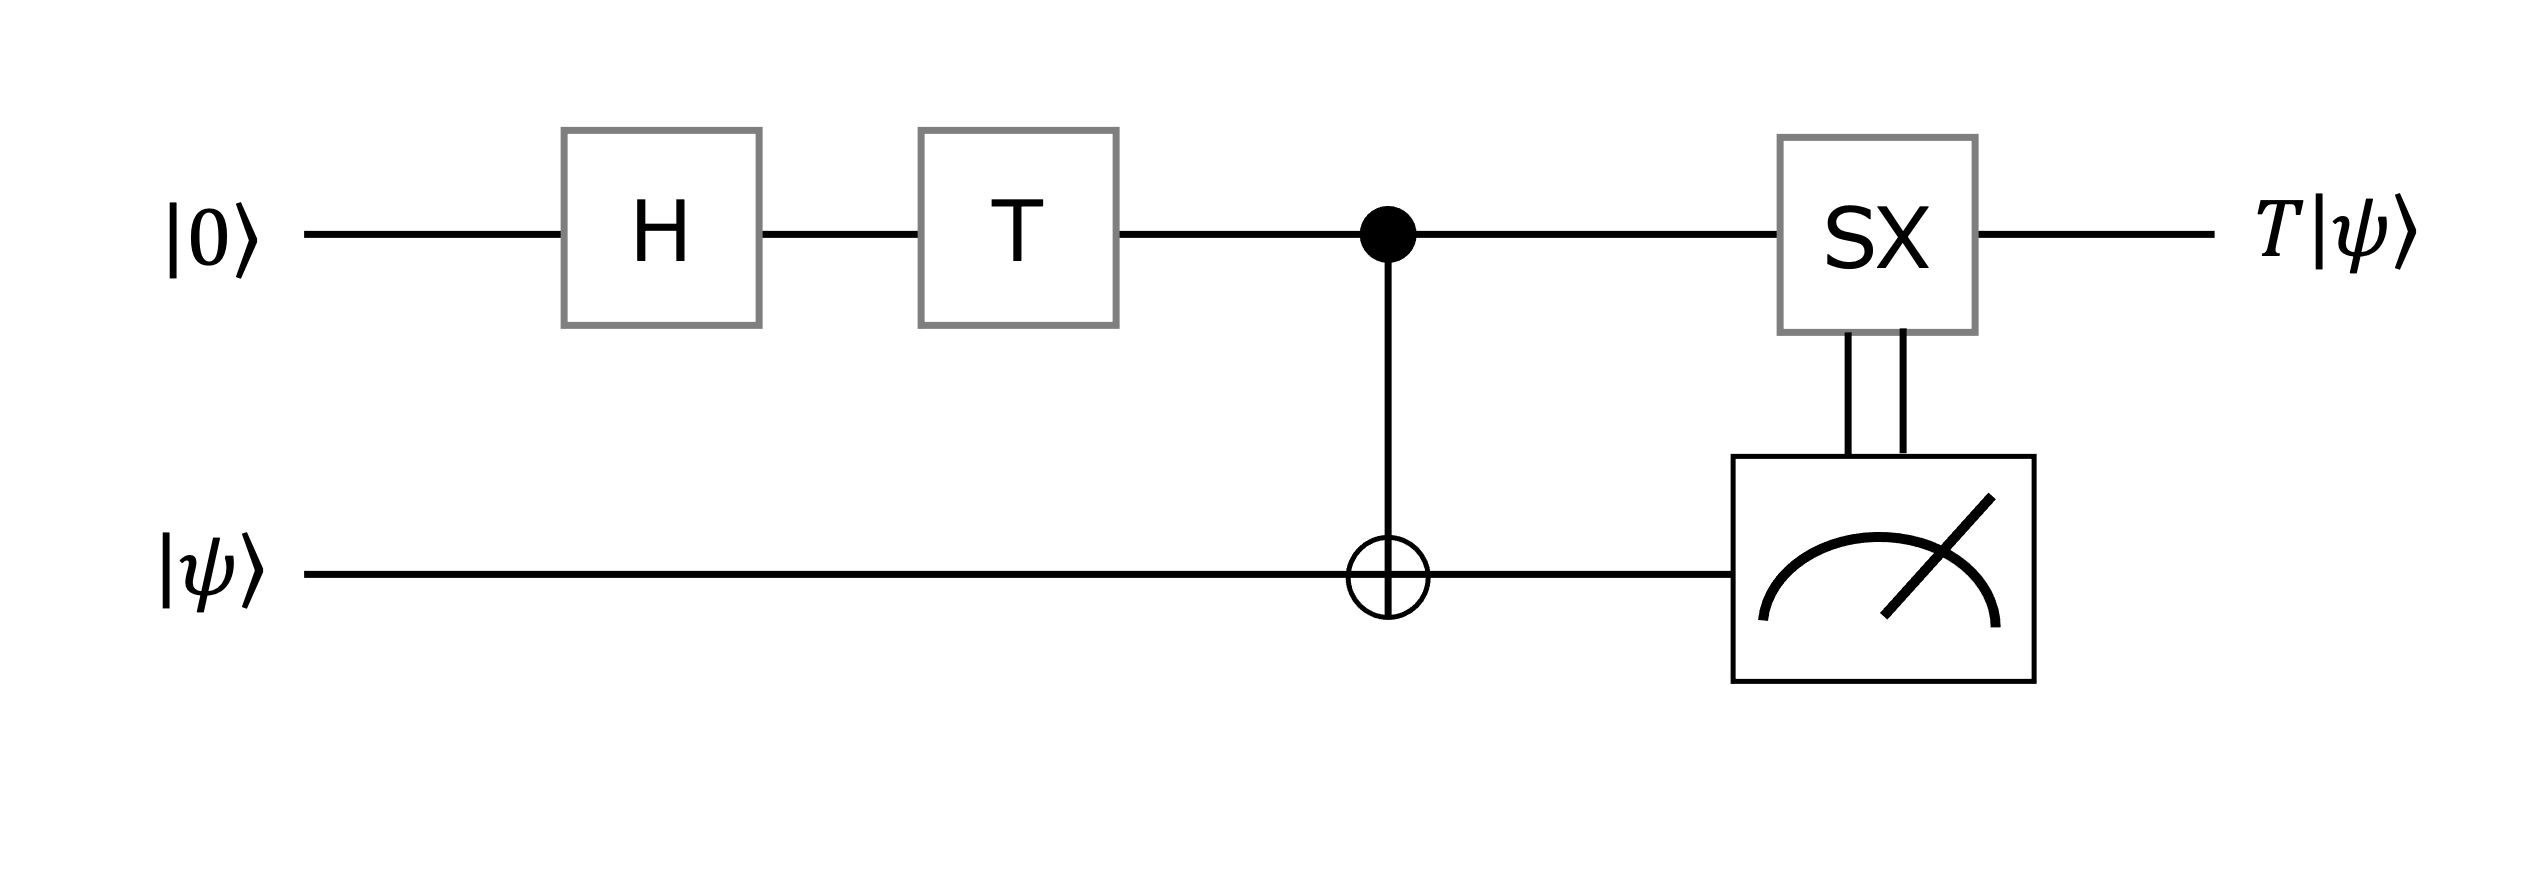

これを先ほどの回路と組み合わせます。

In [ ]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
circ = QuantumCircuit(qr, cr)


circ.h(1)

circ.barrier()

# 量子テレポーテーション
circ.h(0)
circ.t(0)

circ.cx(0, 1)

circ.measure(qr[1], cr[1])

with circ.if_test((cr[1], 0b1)):
  circ.sx(0)

circ.barrier()
circ.h(0)

circ.measure(qr[0], cr[0])
circ.draw("mpl")

In [ ]:
result = backend_sim.run(circ, shots=n_shots).result()
plot_histogram(result.get_counts(0))

最上位ビットが0のもの同士を足し合わせると、概ね想定通りの確率になります。

# Steane符号上での実装

steane符号上で操作を実装してみます。

今回は誤り訂正部分は省略します。

In [ ]:
def encode_circ():
  circ = QuantumCircuit(7)

  circ.h(0)
  circ.h(1)
  circ.h(2)

  circ.cx(3, 4)
  circ.cx(3, 5)

  circ.cx(2, 3)
  circ.cx(2, 4)
  circ.cx(2, 6)

  circ.cx(1, 3)
  circ.cx(1, 5)
  circ.cx(1, 6)

  circ.cx(0, 4)
  circ.cx(0, 5)
  circ.cx(0, 6)

  return circ

In [ ]:
encode_instruction = encode_circ().to_instruction()
decode_instruction = encode_circ().inverse().to_instruction()

encode_instruction.name = "encode"
decode_instruction.name = "decode"

In [ ]:
def steane_code_circ() -> QuantumCircuit:
    # 回路の記述
    n_qubits = 14

    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(2)

    circ = QuantumCircuit(qr, cr)

    circ.barrier()

    # 0ビット目に、事前にT|+>状態をつくっておく
    # 注意：本来はこれはFault-torelantな操作ではないです。
    circ.h(3)
    circ.t(3)
    circ.barrier()
    # 符号化
    for i in range(2):
        circ.append(encode_instruction, range(i*7, (i+1)*7))

    circ.barrier()

    # 論理アダマールゲート
    for i in range(7):
        circ.h(i+7)

    circ.barrier()

    # 論理CNOTゲート
    for i in range(7):
        circ.cx(i, i+7)

    # 測定を行い、結果に基づいて論理SXゲートを適用
    circ.append(decode_instruction, range(7, 14))
    circ.measure(qr[10], cr[1])

    with circ.if_test((cr[1], 0b1)):
        for i in range(7):
          circ.h(i)
          circ.s(i)
          circ.s(i)
          circ.s(i)
          circ.h(i)

    # 論理アダマールゲート
    for i in range(7):
        circ.h(i)

    circ.barrier()

    # 復号
    circ.append(decode_instruction, range(7))

    # 測定
    circ.measure(3, 0)

    return circ

In [ ]:
circ = steane_code_circ()

In [ ]:
circ.draw("mpl")

In [ ]:
result_ideal = backend_sim.run(circ.decompose(), shots=n_shots).result()
plot_histogram(result_ideal.get_counts(0))

最上位ビットがターゲットのビットになります。